# Problema 2: Optimización de Ti en Grilla 10×10 con Simulated Annealing
---

## 1. Setup e Imports

In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root: {project_root}")

Project root: /home/riemannintegrable/universidad/cadenas_de_markov/parcial2


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
print("✓ Imports completados")

✓ Imports completados


In [3]:
from src.punto2.morse import preparar_morse_params_array
from src.punto2.grid import crear_grid_inicial, get_Nd_positions_fijas, compute_total_energy_fast
from src.punto2.optimization import simulated_annealing_logarithmic
from src.punto2.optimization.parallel_runs import (
    ejecutar_multiples_runs_logarithmic,
    get_best_run,
    get_run_statistics
)
from src.punto2.analysis import analizar_patron_espacial, interpretar_patron
from src.punto2.visualization import plot_grid_configuration, plot_energy_evolution, plot_multiple_runs_comparison, plot_spatial_metrics
print("✓ Imports del proyecto completados")

✓ Imports del proyecto completados


In [4]:
morse_params = preparar_morse_params_array()
print(f"Parámetros Morse shape: {morse_params.shape}")
print("✓ Parámetros cargados")

Parámetros Morse shape: (3, 3, 3)
✓ Parámetros cargados


## 2. PUNTO 1: Estado y Movimientos

In [5]:
grid_inicial, Ti_inicial, Nd_fijas = crear_grid_inicial(seed=69)
print(f"Grilla shape: {grid_inicial.shape}")
print(f"Fe: {np.sum(grid_inicial == 0)}, Nd: {np.sum(grid_inicial == 1)}, Ti: {np.sum(grid_inicial == 2)}")

Grilla shape: (10, 10)
Fe: 76, Nd: 16, Ti: 8


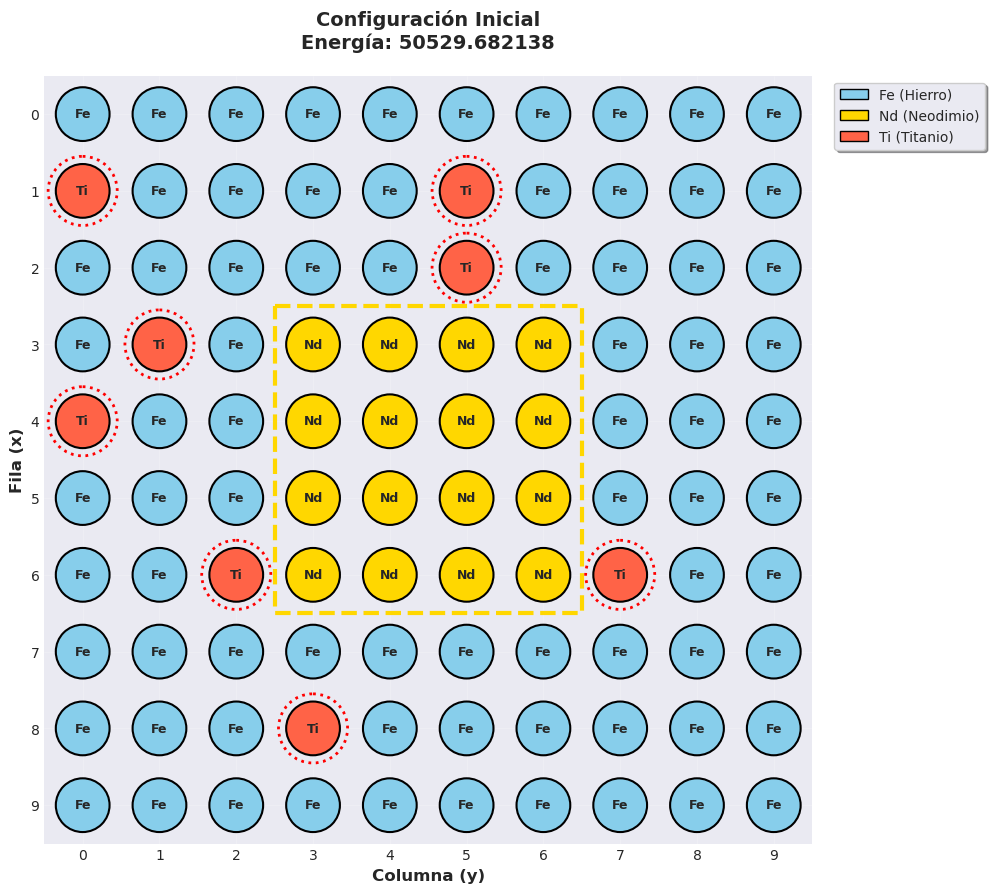

Energía inicial: 50529.682138


In [6]:
energia_inicial = compute_total_energy_fast(grid_inicial, morse_params)
fig = plot_grid_configuration(grid_inicial, Ti_inicial, energia=energia_inicial, title="Configuración Inicial")
plt.show()
print(f"Energía inicial: {energia_inicial:.6f}")

## 3. PUNTO 2: Implementación SA

In [7]:
# Parámetros para Enfriamiento Logarítmico
# T(t) = c / log(t + t₀)
#
# Según el Teorema de Hajek (1988):
# - c debe ser ≥ Δ (profundidad máxima de barreras de energía)
# - t₀ típicamente 2 (para evitar log(0))

c = 3000  # Constante de enfriamiento
t0 = 2    # Offset temporal
max_iter = 5000000  # Número de iteraciones

print("="*70)
print("PARÁMETROS DE SIMULATED ANNEALING - ENFRIAMIENTO LOGARÍTMICO")
print("="*70)
print(f"  Esquema:      T(t) = c / log(t + t₀)")
print(f"  Constante c:  {c}")
print(f"  Offset t₀:    {t0}")
print(f"  Iteraciones:  {max_iter:,}")
print(f"\n  Temperatura inicial:  T(0) = {c / np.log(0 + t0):.2f}")
print(f"  Temperatura final:    T({max_iter:,}) = {c / np.log(max_iter + t0):.2f}")
print("="*70)

PARÁMETROS DE SIMULATED ANNEALING - ENFRIAMIENTO LOGARÍTMICO
  Esquema:      T(t) = c / log(t + t₀)
  Constante c:  3000
  Offset t₀:    2
  Iteraciones:  5,000,000

  Temperatura inicial:  T(0) = 4328.09
  Temperatura final:    T(5,000,000) = 194.49


## 4. PUNTO 3: Análisis de Resultados

In [8]:
N_RUNS = 64

print(f"Ejecutando {N_RUNS} runs en paralelo...")

t_inicio = time.time()
resultados = ejecutar_multiples_runs_logarithmic(
    N_RUNS, 
    c, 
    t0, 
    max_iter, 
    morse_params, 
    n_jobs=-1, 
    verbose=10
)
t_total = time.time() - t_inicio

print(f"\n✓ Completado en {t_total:.2f}s ({t_total/N_RUNS:.2f}s/run)")

Ejecutando 64 runs en paralelo...
Ejecutando 64 runs de Simulated Annealing (logarítmico) en paralelo...
  Parámetros: c=3000, t₀=2, max_iter=5,000,000
  Jobs paralelos: -1 (todos los cores)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  40 out of  64 | elapsed:  1.3min remaining:   45.4s
[Parallel(n_jobs=-1)]: Done  47 out of  64 | elapsed:  1.4min remaining:   29.8s
[Parallel(n_jobs=-1)]: Done  54 out of  64 | elapsed:  1.6min remaining:   18.2s
[Parallel(n_jobs=-1)]: Done  61 out of  64 | elapsed:  1.7min remaining:    5.0s



✓ Completados 64 runs

Estadísticas:
  Mejor energía: 48679.973343
  Peor energía: 48730.150309
  Media: 48712.185703
  Desv. estándar: 22.515743
  Mejora promedio: 4.40%

✓ Completado en 106.48s (1.66s/run)


[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  1.8min finished


In [9]:
mejor_run = get_best_run(resultados)
stats = get_run_statistics(resultados)
print(f"Mejor energía: {mejor_run['energia_final']:.6f}")
print(f"Media: {stats['energia_media']:.6f} ± {stats['energia_std']:.6f}")

Mejor energía: 48679.973343
Media: 48712.185703 ± 22.515743


In [10]:
# Análisis de convergencia del mejor run
print("\n" + "="*70)
print("CONVERGENCIA AL ÓPTIMO - MEJOR RUN")
print("="*70)
print(f"Run ID:                     {mejor_run['run_id']}")
print(f"Iteración de convergencia:  {mejor_run['iterations_to_best']:,}/{max_iter:,}")
print(f"Porcentaje del tiempo:      {(mejor_run['iterations_to_best']/max_iter)*100:.1f}%")
print(f"Temperatura en convergencia: T = {c / np.log(mejor_run['iterations_to_best'] + t0):.2f}")
print("="*70)

# Estadísticas de convergencia de TODOS los runs
iter_convergencias = [r['iterations_to_best'] for r in resultados]
print(f"\nESTADÍSTICAS DE CONVERGENCIA (todos los {N_RUNS} runs):")
print(f"  Media:    {np.mean(iter_convergencias):,.0f} iteraciones")
print(f"  Mediana:  {np.median(iter_convergencias):,.0f} iteraciones")
print(f"  Mínimo:   {np.min(iter_convergencias):,} iteraciones")
print(f"  Máximo:   {np.max(iter_convergencias):,} iteraciones")
print(f"  Std:      {np.std(iter_convergencias):,.0f} iteraciones")
print("="*70)


CONVERGENCIA AL ÓPTIMO - MEJOR RUN
Run ID:                     22
Iteración de convergencia:  4,718,134/5,000,000
Porcentaje del tiempo:      94.4%
Temperatura en convergencia: T = 195.22

ESTADÍSTICAS DE CONVERGENCIA (todos los 64 runs):
  Media:    3,703,366 iteraciones
  Mediana:  4,037,378 iteraciones
  Mínimo:   249,390 iteraciones
  Máximo:   4,994,876 iteraciones
  Std:      1,118,151 iteraciones


### GRÁFICA 1: Configuración Óptima

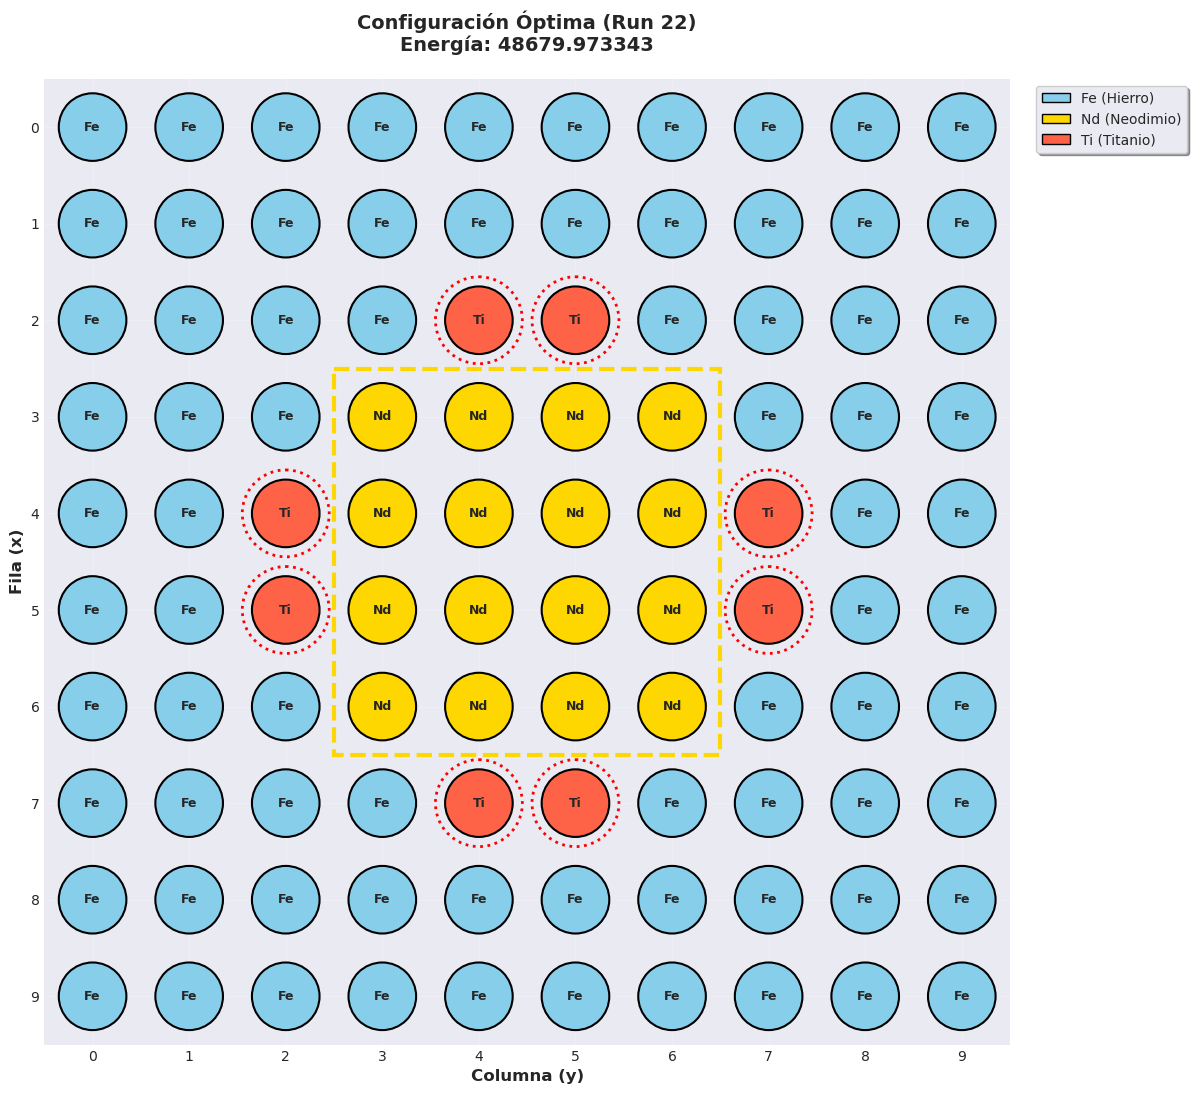

In [11]:
fig = plot_grid_configuration(
    mejor_run['grid_best'], 
    mejor_run['Ti_best'], 
    energia=mejor_run['energia_final'], 
    title=f"Configuración Óptima (Run {mejor_run['run_id']})",
    figsize=(12, 12)
)
plt.show()

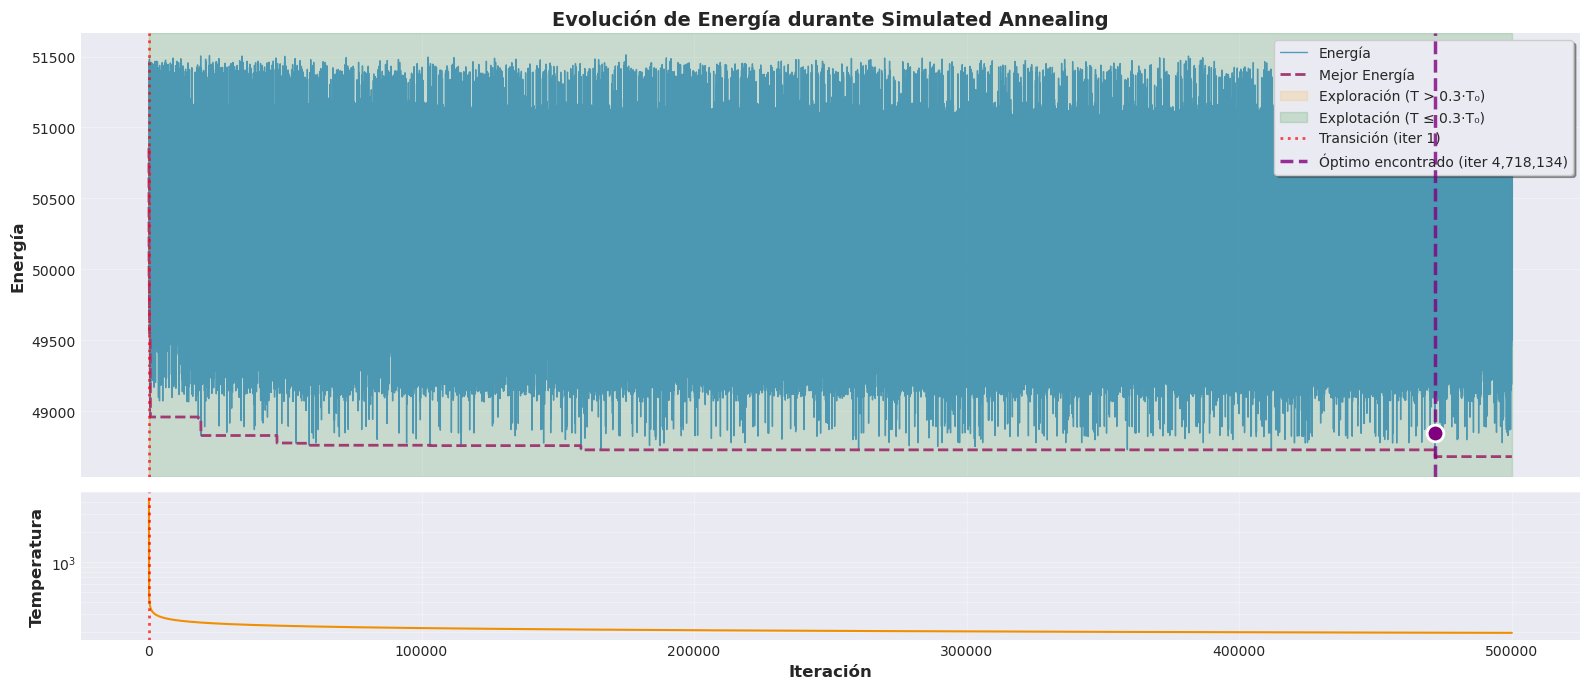


El óptimo se encontró en la iteración 4,718,134 de 5,000,000
(94.4% del tiempo total)
Temperatura en convergencia: T = 195.22


In [12]:
# Preparar history del mejor run
# NOTA: energy_history está submuestreado (solo cada 10 puntos) para ahorrar memoria
iterations_array = np.arange(len(mejor_run['energy_history'])) * 10  # Reconstruir índices reales
history_mejor = {
    'energy': mejor_run['energy_history'],
    'temperature': c / np.log(iterations_array + t0),
    'accepted': np.zeros(len(mejor_run['energy_history']), dtype=bool)
}

# Crear gráfica de evolución de energía
fig = plot_energy_evolution(history_mejor, highlight_phases=True, 
                            exploration_threshold=0.3, figsize=(16, 7))

# AGREGAR MARCA VISUAL DE CONVERGENCIA
ax = fig.axes[0]  # Primer subplot (energía)
iter_best = mejor_run['iterations_to_best']
# Convertir a índice en el array submuestreado
iter_best_idx = iter_best // 10

# Línea vertical en el punto de convergencia
ax.axvline(iter_best_idx, color='purple', linestyle='--', linewidth=2.5, 
           label=f'Óptimo encontrado (iter {iter_best:,})', alpha=0.8, zorder=10)

# Punto marcador en la convergencia (con protección de límites)
if iter_best_idx < len(mejor_run['energy_history']):
    energia_convergencia = mejor_run['energy_history'][iter_best_idx]
    ax.plot(iter_best_idx, energia_convergencia, 'o', color='purple', 
            markersize=12, markeredgecolor='white', markeredgewidth=2, zorder=11)

# Actualizar leyenda
ax.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

# Información de convergencia
T_convergencia = c / np.log(iter_best + t0)
print(f"\nEl óptimo se encontró en la iteración {iter_best:,} de {max_iter:,}")
print(f"({(iter_best/max_iter)*100:.1f}% del tiempo total)")
print(f"Temperatura en convergencia: T = {T_convergencia:.2f}")

### Análisis Espacial

In [13]:
patron = analizar_patron_espacial(mejor_run['Ti_best'], Nd_fijas, grid_size=10)
print("\nANÁLISIS ESPACIAL")
print(f"Dist. Ti-Nd promedio: {patron['dist_Ti_Nd_promedio']:.3f} Å")
print(f"Dist. Ti-Ti promedio: {patron['dist_Ti_Ti_promedio']:.3f} Å")
print(f"Clustering score: {patron['clustering_score']:.3f}")
print(f"Dist. al centro: {patron['dist_centro_promedio']:.3f}")


ANÁLISIS ESPACIAL
Dist. Ti-Nd promedio: 1.000 Å
Dist. Ti-Ti promedio: 3.626 Å
Clustering score: 0.715
Dist. al centro: 2.550


In [14]:
interpretacion = interpretar_patron(patron)
print("\nINTERPRETACIÓN:")
print(interpretacion)


INTERPRETACIÓN:
Los átomos de Ti se ubican relativamente CERCA de los átomos de Nd (distancia promedio: 1.00 Å).
Los Ti se distribuyen cerca del CENTRO de la grilla (distancia al centro: 2.55).
Los Ti tienden a AGRUPARSE (clustering score: 0.715, dist. promedio Ti-Ti: 3.63 Å).

✗ Este patrón NO confirma completamente la hipótesis del Punto 1.


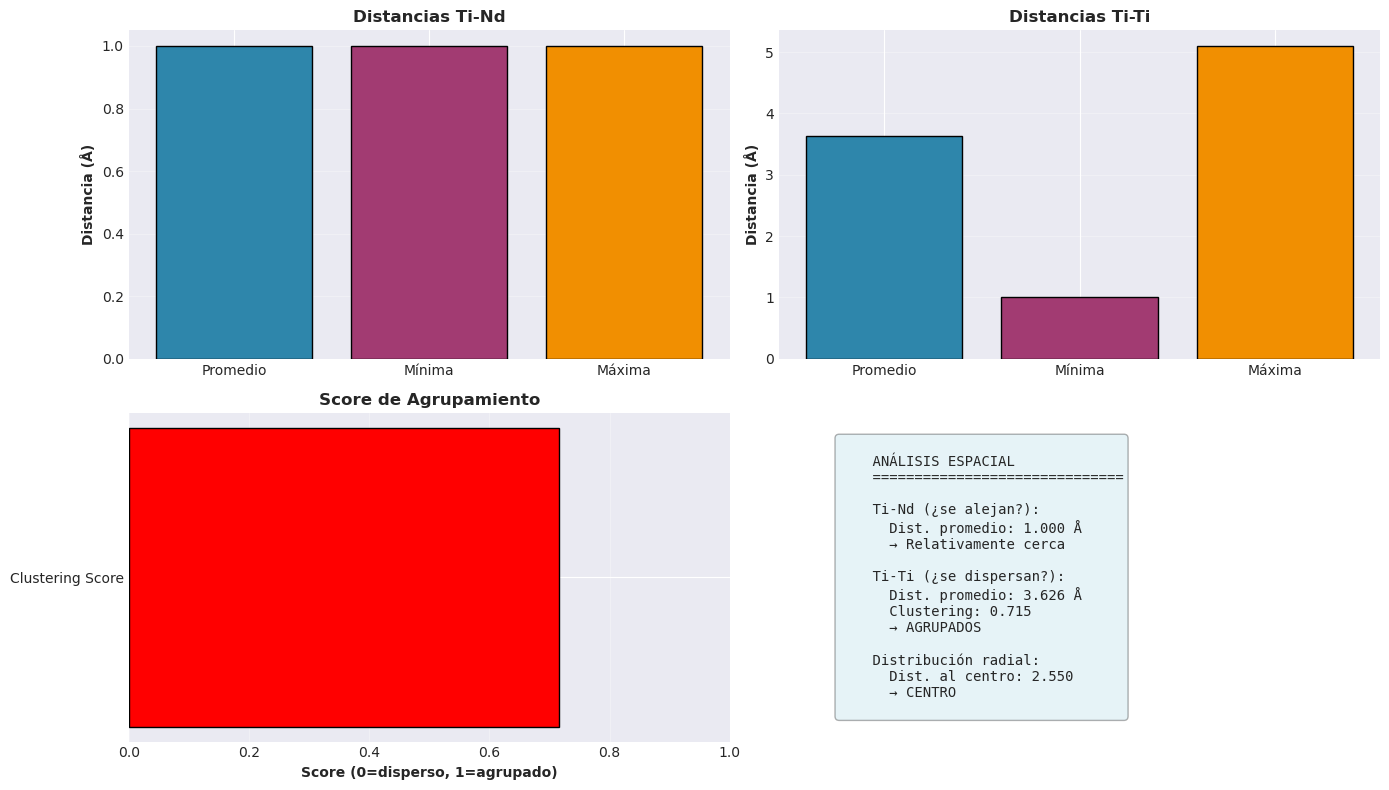

In [15]:
fig = plot_spatial_metrics(patron, figsize=(14, 8))
plt.show()